In [1]:
from scwfae.data.ptbxlDS import PtbxlAllChanDS
from scwfae.model.ConvolutionalEcgModules import ConvolutionalEcgVAE
import torch
from torch.utils.data import random_split, DataLoader

torch.manual_seed(42)

-- SCWFAE --


In [2]:
ds = PtbxlAllChanDS(lowres=True)
_, val_ds = random_split(ds, lengths=[0.9, 0.1])
val_dl = DataLoader(val_ds, batch_size=len(val_ds))

sig, labels = next(iter(val_dl))
sig.shape

done


torch.Size([1886, 12, 1000])

In [20]:
LATENT_DIM = 2

m = ConvolutionalEcgVAE(n_filters=32, latent_dim=LATENT_DIM)
# m.load_state_dict(torch.load('cache/archivedmodels/ecgvae_f8l64.pt', weights_only=True))
m.load_state_dict(torch.load('cache/savedmodels/ecgvae.pt', weights_only=True))
m.eval()
m

ConvolutionalEcgVAE(
  (encoder): ConvolutionalEcgEncoder(
    (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv2): Conv1d(32, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder): ConvolutionalEcgDecoder(
    (conv1): ConvTranspose1d(1024, 32, kernel_size=(3,), stride=(1,))
    (conv2): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(1,))
  )
  (fc_mean): Linear(in_features=1024, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=1024, bias=True)
)

In [21]:
n, channels, sig_len = sig.shape

with torch.no_grad():
    encodings = m.encode(sig.view(n* channels, sig_len).unsqueeze(1))
    
encodings = encodings.view(n, channels * LATENT_DIM)
encodings.shape


torch.Size([1886, 24])

In [22]:

from torch.nn.functional import mse_loss

with torch.no_grad():
    reconstructions, _, _ = m(sig.view(n* channels, sig_len).unsqueeze(1))
    
mse_loss(reconstructions, sig.view(n*channels, sig_len).unsqueeze(1), reduction='mean')


tensor(0.0071)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for label_name, y in labels.items():
    if y.sum() > 10:
        clf = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(clf, encodings.detach().numpy(), y.detach().numpy(), cv=5, scoring='roc_auc')
        print(f"{label_name}: {scores.mean()}")
    else:
        print(f"Insufficient positive examples: {label_name}")

CD: 0.6210264467244989
HYP: 0.724292324442025
MI: 0.5800412586220564
NORM: 0.6542037032825985
STTC: 0.5186924460768697


<Axes: xlabel='None', ylabel='None'>

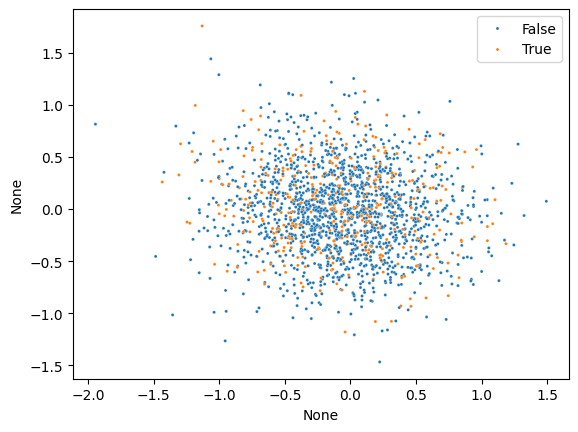

In [31]:
import seaborn as sns

LOI = 'STTC'

lead1 = encodings.view(n, channels, LATENT_DIM)[:,0,:]
lead1.shape
sns.scatterplot(x=lead1[:, 0], y=lead1[:, 1], hue=labels[LOI].detach().numpy(), s=5)
